In [1]:
import rps.robotarium as robotarium
from rps.utilities.transformations import *
from rps.utilities.barrier_certificates import *
from rps.utilities.misc import *
from rps.utilities.controllers import *

import numpy as np
import scipy.stats as st
import time    

In [22]:
control_space_size = 3

U_space_1 = np.array(np.linspace((-0.5),(0.5),control_space_size))
U_space_2 = np.array(np.linspace((-0.5),(0.5),control_space_size))
time_step = 0.033

In [25]:
def model_step(x,velocities,time_step):
    poses = np.zeros((2,1))
    
    # Update dynamics of agents
    poses[0] = x[0] + time_step*velocities[0]
    poses[1] = x[1] + time_step*velocities[1]
    
    return(poses)


def lb_ub_support(mu,cov):
    
    # Calculate the lower and upper bounds with 95% confidence
    z = st.norm.ppf(0.975) 
    lower_bound = mu - z * np.diag(np.linalg.cholesky(cov))
    upper_bound = mu + z * np.diag(np.linalg.cholesky(cov))
    
    return(lower_bound,upper_bound)

def q_constant(lower_bound,upper_bound):
    length = np.array(upper_bound-lower_bound)

    area = np.product(length)
    
    q_constant = 1/area
    
    return(q_constant)

def my_logpdf(x, u, covar):
    k = len(x)  # dimension
    a = np.transpose(x - u)
    b = np.linalg.inv(covar)
    c = x - u
    d = np.matmul(a, b)
    e = np.matmul(d, c)
    numer = np.exp(-0.5 * e)
    f = (2 * np.pi)**k
    g = np.linalg.det(covar)
    denom = np.sqrt(f * g)
    pdf = numer / denom
    return pdf

def multivariate_rbf_kernel(X1, X2, gamma):
    #Compute the multivariate Radial Basis Function (RBF) kernel between two sets of input points.
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.zeros((n1, n2))

    diff = X1[:] - X2[:]
    K = np.exp(-gamma * np.dot(diff, diff))

    return K

def state_cost(state,goal_points,obs_points):
    v = np.array([0.02, 0.02], dtype=np.float32)
    covar = np.diag(v)
    gauss_sum = 0
    
    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += 20*my_logpdf(state[:2],obs_points[:2,i],covar)
        
    cost = 30*((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) + gauss_sum + 10*(np.exp(-0.5*((state[0]-(-1.5))/0.02)**2)/(0.02*np.sqrt(2*np.pi)) 
                + np.exp(-0.5*((state[0]-1.5)/0.02)**2)/(0.02*np.sqrt(2*np.pi)) + np.exp(-0.5*((state[1]-1.0)/0.02)**2)/(0.02*np.sqrt(2*np.pi)) 
                + np.exp(-0.5*((state[1]-(-1.0))/0.02)**2)/(0.02*np.sqrt(2*np.pi)))
    return(cost)

def C_Bar(state,goal_points):
    
    #ind = discretize(state, 2, [-np.pi, -5], [2*np.pi/50, 0.2])
    Cost = np.zeros((10,10)) #initialize cost
    #Cost = 0
    
    for i in range(10):
            for j in range(10):
                next_state = model_step(state,[U_space_1[i],U_space_2[j]],time_step)
                cov = np.array([[1, 0.5, 0.3], [0.5, 1, 0.2], [0.3, 0.2, 1]])
                f = st.multivariate_normal(next_state.reshape((3,)),cov)
                next_state = f.rvs()
                cost = state_cost(next_state,goal_points)
                Cost[i,j] = cost
    
    Expected_Cost = np.sum(Cost*(1/100))
                
    return(Expected_Cost)
    
def Control_step(state,U_space_1,U_space_2,goal_points,obs_points):
        ###
        #Perform an FPD step given an expert input, by first getting the corresponding pf and then applying the FPD solution
        #tpf = stats.norm.pdf(u_axis, u, 0.2) #Input pf
        #S = np.sum(tpf) #Normalizing input pf
        
        target_pf = 1/control_space_size**2
        time_step = 0.033
        #ind = discretize(self.state, 2, [-np.pi, -5], [2*np.pi/50, 0.2]) #Discretize the state index for DKL calculation
        
        pf = np.zeros((control_space_size,control_space_size)) #Initialize pf
        for i in range(control_space_size):
            for j in range(control_space_size):
                next_state = model_step(state,[U_space_1[i],U_space_2[j]],time_step)
                cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
                f = st.multivariate_normal(next_state.reshape((2,)),cov)
                N_samples = 20
                next_sample = f.rvs(N_samples)

                #next_sample = np.reshape(next_sample,(2,N_samples))

                cost=0
                for k in range(N_samples):
                    cost+=state_cost(next_sample[k,:],goal_points,obs_points)

                #lb,ub = lb_ub_support(next_state,cov)
                #q_const = q_constant(lb,ub)
                #f = plant_actual[ind[0],ind[1],i] #Get the actual and demonstrator plants from the binned data
                #g = plant_target[ind[0],ind[1],i]
                log_DKL = np.exp(-(-f.entropy())-cost/N_samples)
                #log_DKL = np.exp(-(-f.entropy()-np.log(q_const))-cost/N_samples)
                pf[i,j] = log_DKL #Calculate the DKL for each possible input, get corresponding probability
        S2 = np.sum(pf) #Normalize resulting policy
        #print(pf)
        pf = np.array([x/S2 for x in pf])
        #action = np.random.choice(u_axis, p=pf) #Select a random action from the new policy
        #previous_action = action
        #self.step(action) #Simulation step
        
        flat = pf.flatten()

        sample_index = np.random.choice(a=flat.size, p=flat)

        # Take this index and adjust it so it matches the original array
        adjusted_index = np.unravel_index(sample_index, pf.shape)
        #print(adjusted_index)

        action = np.reshape(np.array([U_space_1[adjusted_index[0]],U_space_2[adjusted_index[1]]]),(2,1))
        
        return(action)

In [24]:
# Define goal points by removing orientation from poses
goal_points = np.array(np.mat('-1.4; -0.8; 0'))

obs_points = np.array(np.mat('0 0 0 0 0 -0.8;0 0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0 0'))

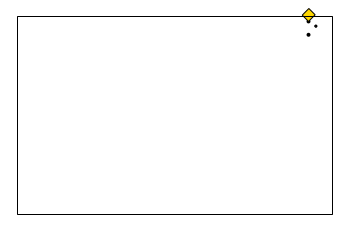

##### DEBUG OUTPUT #####
Your simulation will take approximately 25 real seconds when deployed on the Robotarium. 

	 Simulation had 713 iteration(s) where the actuator limits were exceeded.


<Figure size 432x288 with 0 Axes>

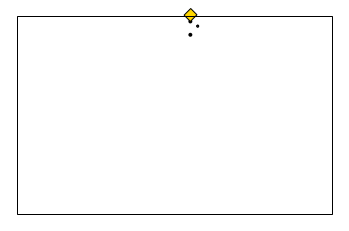

##### DEBUG OUTPUT #####
Your simulation will take approximately 25 real seconds when deployed on the Robotarium. 

	 Simulation had 1409 iteration(s) where the actuator limits were exceeded.


<Figure size 432x288 with 0 Axes>

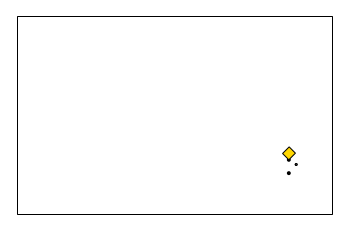

##### DEBUG OUTPUT #####
Your simulation will take approximately 57 real seconds when deployed on the Robotarium. 

	 Simulation had 2912 iteration(s) where the actuator limits were exceeded.


<Figure size 432x288 with 0 Axes>

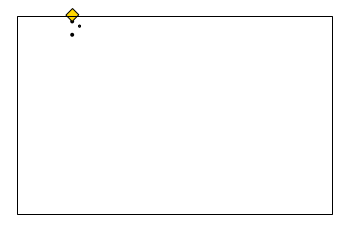

##### DEBUG OUTPUT #####
Your simulation will take approximately 12 real seconds when deployed on the Robotarium. 

	 Simulation had 3248 iteration(s) where the actuator limits were exceeded.


<Figure size 432x288 with 0 Axes>

In [26]:
# Instantiate Robotarium object
N = 1
initial_conditions = [np.array(np.mat('1.4;0.9; 0')),np.array(np.mat('0.2;0.9; 0')),np.array(np.mat('1.2;-0.5; 0')),np.array(np.mat('-1;0.9; 0'))]
N_experiment = 4
X_Si = [0]*N_experiment
D_Xi = [0]*N_experiment

for I in range(N_experiment):
    
    X_si = []
    D_xi = []

    r = robotarium.Robotarium(number_of_robots=N, show_figure=True, initial_conditions=initial_conditions[I], sim_in_real_time=False)

    # Create single integrator position controller
    single_integrator_position_controller = create_si_position_controller()

    # Create barrier certificates to avoid collision
    #si_barrier_cert = create_single_integrator_barrier_certificate()
    si_barrier_cert = create_single_integrator_barrier_certificate_with_boundary()

    _, uni_to_si_states = create_si_to_uni_mapping()

    # Create mapping from single integrator velocity commands to unicycle velocity commands
    si_to_uni_dyn = create_si_to_uni_dynamics_with_backwards_motion()

    # define x initially
    x = r.get_poses()
    x_si = uni_to_si_states(x)
    
    # Plotting Parameters
    CM = np.random.rand(N+10,3) # Random Colors
    goal_marker_size_m = 0.15
    obs_marker_size_m = 0.15
    #robot_marker_size_m = 0.1
    marker_size_goal = determine_marker_size(r,goal_marker_size_m)
    marker_size_obs = determine_marker_size(r,obs_marker_size_m)
    #marker_size_robot = determine_marker_size(r, robot_marker_size_m)
    font_size = determine_font_size(r,0.1)
    line_width = 5

    # Create Goal Point Markers
    #Text with goal identification
    goal_caption = ['G{0}'.format(ii) for ii in range(goal_points.shape[1])]
    #Plot text for caption
    goal_points_text = [r.axes.text(goal_points[0,ii], goal_points[1,ii], goal_caption[ii], fontsize=font_size, color='k',fontweight='bold',horizontalalignment='center',verticalalignment='center',zorder=-2)
    for ii in range(goal_points.shape[1])]
    goal_markers = [r.axes.scatter(goal_points[0,ii], goal_points[1,ii], s=marker_size_goal, marker='s', facecolors='none',edgecolors=CM[ii,:],linewidth=line_width,zorder=-2)
    for ii in range(goal_points.shape[1])]
    #robot_markers = [r.axes.scatter(x[0,ii], x[1,ii], s=marker_size_robot, marker='o', facecolors='none',edgecolors=CM[ii,:],linewidth=line_width) 
    #for ii in range(goal_points.shape[1])]

    #Text with goal identification
    obs_caption = ['OBS{0}'.format(ii) for ii in range(obs_points.shape[1])]
    #Plot text for caption
    obs_points_text = [r.axes.text(obs_points[0,ii], obs_points[1,ii], obs_caption[ii], fontsize=font_size, color='k',fontweight='bold',horizontalalignment='center',verticalalignment='center',zorder=-2)
    for ii in range(obs_points.shape[1])]
    obs_markers = [r.axes.scatter(obs_points[0,ii], obs_points[1,ii], s=marker_size_obs, marker='s', facecolors='none',edgecolors=CM[ii+1,:],linewidth=line_width,zorder=-2)
    for ii in range(obs_points.shape[1])]

    r.step()
    
        # While the number of robots at the required poses is less
    # than N...
    while (np.size(at_pose(np.vstack((x_si,x[2,:])), goal_points, position_error=0.15,rotation_error=100)) != N):

        # Get poses of agents
        x = r.get_poses()
        x_si = uni_to_si_states(x)
        
        #Add to the dataset
        X_si.append(x_si)
        
        cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
        x_pdf = st.multivariate_normal(x_si.reshape((2,)),cov)
        x_sample = x_pdf.rvs()
        

        for j in range(goal_points.shape[1]):
            goal_markers[j].set_sizes([determine_marker_size(r, goal_marker_size_m)])
        
        for j in range(obs_points.shape[1]):
            obs_markers[j].set_sizes([determine_marker_size(r, obs_marker_size_m)])

        # Create single-integrator control inputs
        #dxi = single_integrator_position_controller(x_si, goal_points[:2][:])
        dxi = Control_step(x_sample,U_space_1,U_space_2,goal_points,obs_points)
        
        D_xi.append(dxi)
        
        # Transform single integrator velocity commands to unicycle
        dxu = si_to_uni_dyn(dxi, x)

        # Set the velocities by mapping the single-integrator inputs to unciycle inputs
        r.set_velocities(np.arange(N), dxu)
        # Iterate the simulation
        r.step()
        
    D_Xi[I] = D_xi
    X_Si[I] = X_si

    #Call at end of script to print debug information and for your script to run on the Robotarium server properly
    r.call_at_scripts_end()   

In [27]:
np.save('State_Data2.npy',X_Si)
np.save('Input_Data2.npy',D_Xi)

c:\Users\jamal\anaconda3\envs\mbrl\lib\site-packages\numpy\lib\npyio.py:501: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [28]:
XX = np.load('State_Data2.npy',allow_pickle=True)
UU = np.load('Input_Data2.npy',allow_pickle=True)

#XX = np.load(r'D:\Network Security\KL Control\robotarium_python_simulator\State_Data_Simulation.npy',allow_pickle=True)
#UU = np.load(r'D:\Network Security\KL Control\robotarium_python_simulator\Input_Data_Simulation.npy',allow_pickle=True)

In [29]:
X = []
X_plot = []
U = []
U_plot = []

for i in range(len(XX)):
    X.append(np.array(XX[i]))
    X_plot.append(np.array(XX[i]))

X = np.concatenate(X, axis=0)
X = np.reshape(X, (-1, 2))

U = []
for i in range(len(UU)):
    U.append(np.array(UU[i]))
    U_plot.append(np.array(UU[i]))

U = np.concatenate(U, axis=0)
U = np.reshape(U, (-1, 2))



In [30]:
obs_points_f = np.array(np.mat('0 0 0 0 0 0.8 0.8 0.8 0.8 0.8 -0.8 -0.8 -0.8 -0.8 -0.8;-0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0'))

In [31]:
N_feature = np.size(obs_points_f,axis=1)+1
print(N_feature)

16


In [32]:
def feature(next_state,goal_points,obs_points,N_feature):
    v = np.array([0.02, 0.02], dtype=np.float32)
    covar = np.diag(v)
    features = np.zeros(N_feature)
    for i in range(np.size(obs_points,axis=1)):
        features[i+1] = my_logpdf(next_state[:2],obs_points[:2,i],covar)
        #features[i+1] = multivariate_rbf_kernel(next_state[:2],obs_points[:2,i],15)
        
    features[0] = (((next_state[0]-goal_points[0])**2 + (next_state[1]-goal_points[1])**2))
    #features[-1] = (np.exp(-0.5*((next_state[0]-(-1.5))/0.02)**2)/(0.02*np.sqrt(2*np.pi)) 
    #            + np.exp(-0.5*((next_state[0]-1.5)/0.02)**2)/(0.02*np.sqrt(2*np.pi)) + np.exp(-0.5*((next_state[1]-1.0)/0.02)**2)/(0.02*np.sqrt(2*np.pi)) 
    #            + np.exp(-0.5*((next_state[1]-(-1.0))/0.02)**2)/(0.02*np.sqrt(2*np.pi)))
    
    return features

In [33]:
%%capture
import cvxpy as cp
import numpy as np
import time
M = np.size(X,axis=0) - 1
w = cp.Variable((1,N_feature))
#v = cp.Variable((2,2))
constraints = [w >= 0]
R = np.zeros((99,1))
L = []
#S_axis = np.array([i for i in range(51)])

f_expect = np.zeros((2,20)) 
#features = np.zeros((2,10,10)) 
feature_sampled = np.zeros((N_feature,M))
PF = np.zeros((control_space_size,control_space_size,M))
#pf = np.zeros((10,10))
#Log_DKL = np.zeros((20,M))

for i in range(M):

    #############################################################################################################################
    features = np.zeros((N_feature,control_space_size,control_space_size))
    state = np.array(X[i,:]) #Get the state

    x0 = state.reshape(-1,1)
   
    #target_pf = 1/control_space_size**2
    time_step = 0.033
    #ind = discretize(self.state, 2, [-np.pi, -5], [2*np.pi/50, 0.2]) #Discretize the state index for DKL calculation
        
    pf = np.zeros((control_space_size,control_space_size)) #Initialize pf
    
    for j in range(control_space_size):
        for k in range(control_space_size):
            next_state = model_step(state,[U_space_1[j],U_space_2[k]],time_step)
            cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
            f = st.multivariate_normal(next_state.reshape((2,)),cov)
            next_sample = f.mean
            
            N_samples = 5
            next_samples = f.rvs(N_samples)
            feature_sample = np.zeros((N_feature,N_samples))
            
            for m in range(N_samples):
                feature_sample[:,m] = feature(next_samples[m,:],goal_points,obs_points_f,N_feature)
            #calculating feature
            #features[:,j,k] = feature(next_sample,goal_points,obs_points_f,N_feature)
            features[:,j,k] = np.mean(feature_sample,axis=1)
            
            #lb,ub = lb_ub_support(next_state,cov)
            #q_const = q_constant(lb,ub)
            
            #Calculate the DKL for each possible input, get corresponding probability
            log_DKL = np.exp(-(-f.entropy()))
            pf[j,k] = log_DKL 
    PF[:,:,i] = pf
    
    features = np.reshape(features,(N_feature,control_space_size**2))
    
    #f_sampled = np.reshape(plant_actual[ind[0],ind[1],u_ind],(51,51))
    f_sampled = model_step(state,U[i+1,:],time_step)
    cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
    f1 = st.multivariate_normal(f_sampled.reshape((2,)),cov)
    next_samples_f1 = f1.rvs(N_samples)
    feature_sample_f1 = np.zeros((N_feature,N_samples))
    for n in range(N_samples):
        feature_sample_f1[:,n] = feature(next_samples_f1[n,:],goal_points,obs_points_f,N_feature)
    
    feature_sampled[:,i] = np.mean(feature_sample_f1,axis=1)
    
    L.append(-(w @ feature_sampled[:,i]) + cp.log_sum_exp(cp.reshape(w @ features,(control_space_size**2,)) + cp.log(np.reshape(PF[:,:,i],(control_space_size**2,))))) #Log likelihood for each instance
    
    #L.append(-(w @ feature_sampled[:,i]) + cp.log(cp.sum(cp.exp(cp.reshape(w@ features[:,:,i],(20,))+cp.log(PF[:,i])))))
     
objective = cp.Minimize(cp.sum(L))    
    
prob = cp.Problem(objective)

result = prob.solve(verbose = True)

print("status:", prob.status)
print("optimal value", prob.value)

In [34]:
print('weights:',w.value)

#w = np.array(w)

weights = w.value

np.save('Weights.npy',weights)
#weights.shape

weights: [[-1.58636744e+01  3.17743780e-01  1.10019412e-02 -1.24359947e+01
  -1.89303848e+01 -1.02719287e+01  8.43797936e-02  7.15454247e-01
   5.51033939e-01  1.50131059e-02 -2.66011022e-01 -9.93529589e+00
  -1.07299167e-01  2.27303043e-01 -5.68427401e-01  2.46958842e-01]]


In [35]:
weights = np.load('Weights.npy')

In [36]:
print("status:", prob.status)
print("optimal value", prob.value)

status: optimal
optimal value -7797.822026246321


In [37]:
import numpy as np 
import scipy.stats as st
import pandas as pd

goal_points = np.array(np.mat('-1.4; -0.8; 0'))

obs_points = np.array(np.mat('0 0 0 0 0 -0.8 ;0 0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0 0'))

def my_logpdf(x, u, covar):
    k = len(x)  # dimension
    a = np.transpose(x - u)
    b = np.linalg.inv(covar)
    c = x - u
    d = np.matmul(a, b)
    e = np.matmul(d, c)
    numer = np.exp(-0.5 * e)
    f = (2 * np.pi)**k
    g = np.linalg.det(covar)
    denom = np.sqrt(f * g)
    pdf = numer / denom
    return pdf

def state_cost(state,goal_points,obs_points):
    v = np.array([0.02, 0.02], dtype=np.float32)
    covar = np.diag(v)
    
    v1 = np.array([1, 1], dtype=np.float32)
    covar1 = np.diag(v1)
    #cost = 60*(state[0]-goal_points[0])**2 + 60*(state[1]-goal_points[1])**2 + 200*(np.exp(-(np.abs(state[0]-obs_points[0,0])+np.abs(state[1]-obs_points[1,0]))) + np.exp(-(np.abs(state[0]-obs_points[0,1]) + np.abs(state[1]-obs_points[1,1]))) + np.exp(-(np.abs(state[0]-obs_points[0,2])+np.abs(state[1]-obs_points[1,2])))) #actual cost
    
    gauss_sum = 0
    
    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += 20*my_logpdf(state[:2],obs_points[:2,i],covar)
        #gauss_sum += 100*multivariate_rbf_kernel(state[:2],obs_points[:2,i],100)
        
    cost = 30*((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) + gauss_sum + 0*(np.exp(-0.5*((state[0]-(-1.5))/0.02)**2)/(0.02*np.sqrt(2*np.pi)) 
                + np.exp(-0.5*((state[0]-1.5)/0.02)**2)/(0.02*np.sqrt(2*np.pi)) + np.exp(-0.5*((state[1]-1.0)/0.02)**2)/(0.02*np.sqrt(2*np.pi)) 
                + np.exp(-0.5*((state[1]-(-1.0))/0.02)**2)/(0.02*np.sqrt(2*np.pi)))
    
    #cost = 4.16*np.sqrt((ind[0]-25)**2)+2.44*np.sqrt((ind[1]-25)**2) #estimated cost
    return(cost)


Cost_Map = np.zeros((300,200))
X_axis = np.linspace(-1.5,1.5,300)
Y_axis = np.linspace(-1,1,200)

for i in range(200):
    for j in range(300):
        
        state = np.array([X_axis[j],Y_axis[i]])
        Cost_Map[j,i] = state_cost(state,goal_points,obs_points)

Coat_Map = pd.DataFrame(Cost_Map,index=list(X_axis),columns=Y_axis)

In [39]:
import numpy as np 
import scipy.stats as st



goal_points = np.array(np.mat('-1.4; -0.8; 0'))

obs_points = np.array(np.mat('0 0 0 0 0 -0.8;0 0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0 0'))


def my_logpdf(x, u, covar):
    k = len(x)  # dimension
    a = np.transpose(x - u)
    b = np.linalg.inv(covar)
    c = x - u
    d = np.matmul(a, b)
    e = np.matmul(d, c)
    numer = np.exp(-0.5 * e)
    f = (2 * np.pi)**k
    g = np.linalg.det(covar)
    denom = np.sqrt(f * g)
    pdf = numer / denom
    return pdf

def state_cost(state,goal_points,obs_points,weights):
    #weights = np.reshape(weights,(9,))
    v = np.array([0.02, 0.02], dtype=np.float32)
    covar = np.diag(v)
    
    v1 = np.array([1, 1], dtype=np.float32)
    covar1 = np.diag(v1)
    #cost = 60*(state[0]-goal_points[0])**2 + 60*(state[1]-goal_points[1])**2 + 200*(np.exp(-(np.abs(state[0]-obs_points[0,0])+np.abs(state[1]-obs_points[1,0]))) + np.exp(-(np.abs(state[0]-obs_points[0,1]) + np.abs(state[1]-obs_points[1,1]))) + np.exp(-(np.abs(state[0]-obs_points[0,2])+np.abs(state[1]-obs_points[1,2])))) #actual cost
    
    gauss_sum = 0
    
    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += -weights[:,i+1]*my_logpdf(state[:2],obs_points[:2,i],covar)
        #gauss_sum += -weights[:,i+1]*multivariate_rbf_kernel(state[:2],obs_points[:2,i],15)
        
    cost = -weights[:,0]*((((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2))) + gauss_sum + 0*(np.exp(-0.5*((state[0]-(-1.5))/0.02)**2)/(0.02*np.sqrt(2*np.pi)) 
                + np.exp(-0.5*((state[0]-1.5)/0.02)**2)/(0.02*np.sqrt(2*np.pi)) + np.exp(-0.5*((state[1]-1.0)/0.02)**2)/(0.02*np.sqrt(2*np.pi)) 
                + np.exp(-0.5*((state[1]-(-1.0))/0.02)**2)/(0.02*np.sqrt(2*np.pi)))
    
    #cost = 4.16*np.sqrt((ind[0]-25)**2)+2.44*np.sqrt((ind[1]-25)**2) #estimated cost
    return(cost)


Cost_Map = np.zeros((300,200))
X_axis = np.linspace(-1.5,1.5,300)
Y_axis = np.linspace(-1,1,200)

for i in range(200):
    for j in range(300):
        
        state = np.array ([X_axis[j],Y_axis[i]])
        Cost_Map[j,i] = state_cost(state,goal_points,obs_points_f,weights)

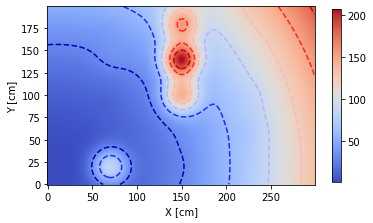

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Create a 2D array of random values
data = np.random.rand(10, 10)

# Transpose the data array to rotate the heatmap
data_rotated = np.transpose(Cost_Map)

# Create a figure and axes
fig, ax = plt.subplots()

# Create a heatmap using imshow()
heatmap = ax.imshow(data_rotated,cmap='coolwarm')

contours = ax.contour(data_rotated,cmap='seismic' , linestyles='dashed')

# Add a colorbar
cbar = plt.colorbar(heatmap,shrink=0.8)

# Add labels and title
ax.set_xlabel('X [cm]')
ax.set_ylabel('Y [cm]')
#ax.set_title('Rotated Heatmap')

ax.invert_yaxis()

# Display the plot
#plt.show()
plt.savefig('Cost_Heat_Map_estimated.jpg',dpi=1000,bbox_inches ='tight')

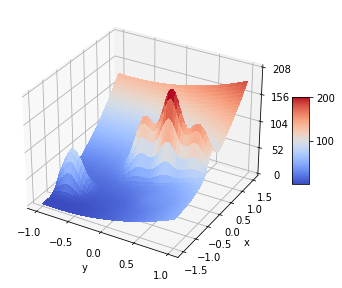

In [41]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np


#fig = plt.figure(figsize=(20, 10))
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig.figure.set_figheight(20)
# Make data.
X_axis = np.linspace(-1.5,1.5,300)
Y_axis = np.linspace(-1,1,200)
X, Y = np.meshgrid(Y_axis, X_axis)


# Plot the surface.
surf = ax.plot_surface(X, Y, Cost_Map, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(5))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.0f}')

ax.set_xlabel('y')
ax.set_ylabel('x')

#ax.view_init(90, 0)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.08, aspect=5)

plt.show()
#plt.savefig('Cost_Map_estimated.jpg',dpi=1000,bbox_inches ='tight')

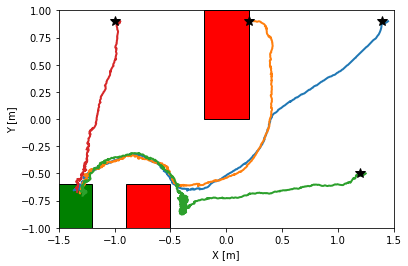

In [42]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

#('1.4;0.9; 0')),np.array(np.mat('0.2;0.9; 0')),np.array(np.mat('1.2;-0.5; 0')),np.array(np.mat('-1;0.9; 0'))]

plt.plot(X_plot[0][:,0],X_plot[0][:,1],linewidth=2)
plt.plot(X_plot[1][:,0],X_plot[1][:,1],linewidth=2)
plt.plot(X_plot[2][:,0],X_plot[2][:,1],linewidth=2)
plt.plot(X_plot[3][:,0],X_plot[3][:,1],linewidth=2)

plt.plot(1.4,0.9,'*',color='black',markersize=10)
plt.plot(0.2,0.9,'*',color='black',markersize=10)
plt.plot(1.2,-0.5,'*',color='black',markersize=10)
plt.plot(-1,0.9,'*',color='black',markersize=10)

#plt.axes()
square1 = plt.Rectangle((-1.6,-1), 0.4, 0.4, fc='green',ec="black")
square3 = plt.Rectangle((-0.9,-1), 0.4, 0.4, fc='red',ec="black")
square2 = plt.Rectangle((-0.2,0), 0.4, 1, fc='red',ec="black")
plt.gca().add_patch(square2)
plt.gca().add_patch(square1)
plt.gca().add_patch(square3)
plt.ylim(-1,1)
plt.xlim(-1.5,1.5)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
#plt.show()
#plt.savefig('Test_Trajectories.jpg',dpi=1000,bbox_inches ='tight')
plt.savefig('Training_Trajectories.jpg',dpi=1000,bbox_inches ='tight')

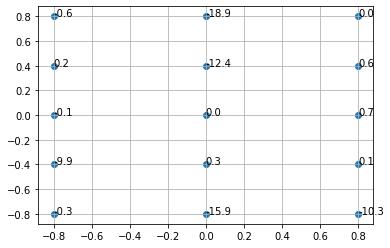

In [43]:
import numpy as np
import matplotlib.pyplot as plt

fig,ax = plt.subplots()

ax.scatter(obs_points_f[0,:],obs_points_f[1,:])

w = np.zeros((15,))

for j in range(15):
    wt = float(weights[:,j])
    w[j] = round(wt,1)

for i, txt in enumerate(w.reshape(15,)):
    ax.annotate(txt,(obs_points_f[0,i],obs_points_f[1,i]))
plt.grid(True)
plt.show()